In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [3]:
# pd.read_csv('../input/test_2v.csv')
address = "train_2v.csv"
df = pd.read_csv(address)
to_drop = ['id']
df = df.drop(to_drop, axis=1).dropna()
df = df.loc[df['gender']!='Other']
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
6,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
7,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
8,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0


In [4]:
for cat in df.select_dtypes('O').columns:
    df[cat] = df[cat].astype('category').cat.codes
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,1,58.0,1,0,1,2,1,87.96,39.2,1,0
3,0,70.0,0,0,1,2,0,69.04,35.9,0,0
6,0,52.0,0,0,1,2,1,77.59,17.7,0,0
7,0,75.0,0,1,1,3,0,243.53,27.0,1,0
8,0,32.0,0,0,1,2,0,77.67,32.3,2,0


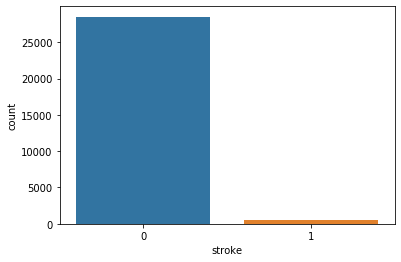

In [5]:
import seaborn as sns
sns.countplot("stroke",data=df)

In [6]:
count_class_0, count_class_1 = df['stroke'].value_counts()

# Divide by class
df_class_0 = df[df['stroke'] == 0]
df_class_1 = df[df['stroke'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)
print(df_under['stroke'].value_counts())
df = df_under

1    548
0    548
Name: stroke, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke',axis=1),df['stroke'])

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train,y_train)

rf.score(X_test,y_test)

/home/monad/anaconda3/envs/tff/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7007299270072993

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_leaf=10, n_estimators=100).fit(X_train,y_train)
# from sklearn.model_selection import GridSearchCV
# param = {'n_estimators':[500,200,100],'min_samples_leaf':[10,20,50]}
# grid = GridSearchCV(clf,param).fit(X_train,y_train)
# print(grid.best_params_)
rf_pred = rf.predict(X_test)
print(rf.score(X_test,y_test))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,rf_pred))

0.8065693430656934
[[ 92  37]
 [ 16 129]]


In [10]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier().fit(X_train,y_train)
gbdt_pred = gbdt.predict(X_test)
gbdt_prob = gbdt.predict_proba(X_test)

In [11]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
dummy_majority.score(X_test,y_test)

0.4708029197080292

In [12]:
rf_pred = rf.predict(X_test)
dummy_majority_pred = dummy_majority.predict(X_test)
print(confusion_matrix(y_test,rf_pred))
print(confusion_matrix(y_test,dummy_majority_pred))

[[ 92  37]
 [ 16 129]]
[[129   0]
 [145   0]]


In [13]:
from sklearn.metrics import accuracy_score,recall_score, roc_auc_score, confusion_matrix
print(accuracy_score(y_test,rf_pred))
print(recall_score(y_test,rf_pred))
# print(roc_auc_score(y_test,pred))
print(confusion_matrix(y_test,rf_pred))

0.8065693430656934
0.8896551724137931
[[ 92  37]
 [ 16 129]]


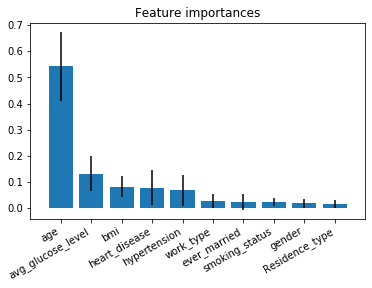

In [14]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
col_name = df.drop('stroke',axis=1).columns.values
# Plot the feature importances of the forest
import matplotlib.pyplot as plt
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]),
        importances[indices],
        yerr=std[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), np.array(col_name)[indices])
plt.xlim([-1, X_train.shape[1]])
fig.autofmt_xdate()
plt.show()

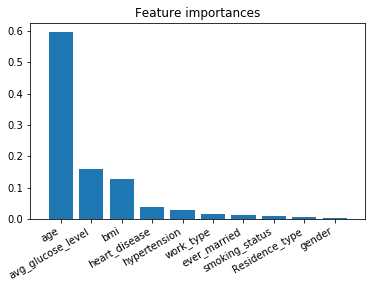

In [15]:
importances = gbdt.feature_importances_
indices = np.argsort(importances)[::-1]
col_name = df.drop('stroke',axis=1).columns.values
# Plot the feature importances of the forest
import matplotlib.pyplot as plt
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), np.array(col_name)[indices])
plt.xlim([-1, X_train.shape[1]])
fig.autofmt_xdate()
plt.show()

In [19]:
import graphviz
from sklearn import tree
dt = tree.DecisionTreeClassifier(min_samples_leaf=30).fit(X_train,y_train)
dt_pred = dt.predict(X_test)

feature_names = df.drop('stroke',axis=1).columns.values
target_names = ['well','stroke']

dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("dt_stroke") 

'dt_stroke.pdf'

In [1]:
graphviz.Source(dot_data).view()

NameError: name 'graphviz' is not defined